<a href="https://colab.research.google.com/github/priharumi/phs/blob/main/PROJETO_MC_DETECCAO_FRAUDE_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TEMA DO PROJETO: Detecção de fraudes em transações de Cartão de Crédito**

*Contexto*: É importante que as empresas de cartão de crédito sejam capazes de reconhecer transações fraudulentas para que os clientes não sejam cobrados por itens que não compraram.

*Conteúdo*: O conjunto de dados contém transações realizadas com cartões de crédito em setembro de 2013 por titulares de cartões europeus. Este conjunto de dados apresenta transações ocorridas em dois dias, com 492 fraudes em um total de 284.807 transações. O conjunto de dados é altamente desbalanceado, com a classe positiva (fraudes) representando 0,172% de todas as transações.

*Dados disponíveis*:

TEMPO = A característica 'Tempo' contém os segundos decorridos entre cada transação e a primeira transação no conjunto de dados.

VALOR = É o valor da transação.

CLASSE = A característica 'Classe' é a variável resposta e assume o valor 1 em caso de fraude e 0 caso contrário.

*Inspiração*: Identificar transações fraudulentas com cartão de crédito.

Considerando o desequilíbrio entre as classes, recomendamos medir a acurácia usando a Área Sob a Curva de Precisão-Revocação (AUPRC). A acurácia da matriz de confusão não é significativa para classificação desbalanceada.





BLOCO 1: IMPORTAÇÃO DE BIBLIOTECAS E DADOS

In [1]:
# 1) Importacao de bibliotecas
import pandas as pd                     # Biblioteca para manipular tabelas
from scipy.io import arff              # Biblioteca para ler arquivos .arff
import urllib.request                  # Biblioteca para baixar arquivos da internet
import os                              # Biblioteca para gerenciar arquivos do sistema
import numpy as np
# Bibliotecas de Machine Learning (Scikit-Learn)
from sklearn.preprocessing import StandardScaler # Para padronizar valores (escala)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score # Para dividir treino/teste
from sklearn.ensemble import RandomForestClassifier # O algoritmo de Machine Learning
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, RocCurveDisplay,
                             PrecisionRecallDisplay, roc_auc_score,f1_score) # Métricas
import matplotlib.pyplot as plt        # Para gerar gráficos

# 2) Define a URL do DATASET - arquivo ARFF no OpenML
url_arff = "https://openml.org/data/v1/download/21756045/CreditCardFraudDetection.arff"

# 3) Nome do arquivo local que será salvo (na pasta atual do notebook)
nome_arquivo_local = "CreditCardFraudDetection.arff"

# 4) Se o arquivo ainda não existir na pasta, faz download
#    Isso evita baixar de novo toda vez
if not os.path.exists(nome_arquivo_local):
    print("Baixando arquivo ARFF do OpenML...")
    urllib.request.urlretrieve(url_arff, nome_arquivo_local)
    print("Download concluído!")
else:
    print("Arquivo ARFF já existe localmente, usando o arquivo existente.")

# 5) Carrega o arquivo ARFF baixado
data, meta = arff.loadarff(nome_arquivo_local)

# 6) Converte os dados em um DataFrame do pandas (tabela)
df = pd.DataFrame(data)

# 7) Mostra as primeiras linhas e os formatos
print(df.head())
print("Dimensões do dataset (linhas, colunas):", df.shape)
print(df.dtypes)



Baixando arquivo ARFF do OpenML...
Download concluído!
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  

BLOCO 2: LIMPEZA E PREPARAÇÃO (Pré-processamento)


In [2]:
# Verificamos no bloco anterior que o tipo da coluna 'CLASS' é FLOAT e no caso devemos alterar para o tipo INT para poder representar corretamente as categorias binárias no machine learning

# As colunas V1 até V28 são resultado de uma transformação PCA. Isso significa que a dimensionalidade original foi reduzida para proteger dados sensíveis.

# Correção da coluna class:
# 1. .astype(float): Converte o texto "0.0" para o número decimal 0.0
# 2. .astype(int): Converte o decimal 0.0 para o inteiro 0
df['Class'] = df['Class'].astype(float).astype(int)

print(f"Dimensões do Dataset: {df.shape}")
print(f"Tipo novo da coluna 'class': {df['Class'].dtype}")
print(f"Valores únicos finais: {df['Class'].unique()}")

# Padronização
# Amount e Time têm escalas muito diferentes das colunas V. Precisamos normalizar.
scaler = StandardScaler()
df['Amount_Scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_Scaled'] = scaler.fit_transform(df[['Time']])

# Separando X (Entradas/Features) e y (Saida/Alvo/Target)
X = df.drop(['Class', 'Time', 'Amount'], axis=1)
y = df['Class']


Dimensões do Dataset: (284807, 31)
Tipo novo da coluna 'class': int64
Valores únicos finais: [0 1]


BLOCO 3: DIVISÃO DOS DADOS

In [3]:
# Método 1: Hold-out (Separação simples Treino/Teste)
# Útil para gerar os gráficos finais de avaliação.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 'stratify=y' é crucial aqui pois, como visto nas aulas, mantém a proporção da classe minoritária (fraude) igual nos dois conjuntos.

BLOCO 4: TREINAMENTO DO MODELO

In [4]:
print("\nIniciando treinamento do Random Forest...")
# class_weight='balanced': Ajusta o custo do erro
model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)
print("Modelo treinado!")


Iniciando treinamento do Random Forest...
Modelo treinado!


BLOCO 5: VALIDAÇÃO CRUZADA

In [5]:
# O professor enfatizou na Aula 06 que só um teste não garante generalização.
# Vamos rodar o K-Fold para ter certeza estatística.

print("\nExecutando Validação Cruzada (Stratified K-Fold)...")
# Usamos StratifiedKFold porque o dataset é desbalanceado e garante que a divisão tenham exatamente a mesma proporção de fraudes e não 'quebrar' o modelo na hora do treino
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)   #divide o dataset em 3 partes iguais / shuffle = embaralhar os dados / random_state = semente aleatória

# Vamos avaliar usando 'f1' (média harmônica entre precisão e recall)
scores = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1)    #O f1 é uma nota muito mais rigorosa: ela só é alta se o modelo tiver Precisão E Recall bons ao mesmo tempo. É a média harmônica entre os dois.

print(f"Média do F1-Score na Validação Cruzada: {scores.mean():.4f} (+/- {scores.std():.4f})")
print("Isso prova que o resultado do modelo não foi 'sorte' de uma divisão específica.")


Executando Validação Cruzada (Stratified K-Fold)...
Média do F1-Score na Validação Cruzada: 0.8415 (+/- 0.0089)
Isso prova que o resultado do modelo não foi 'sorte' de uma divisão específica.


BLOCO 6: AVALIAÇÃO E GRÁFICOS

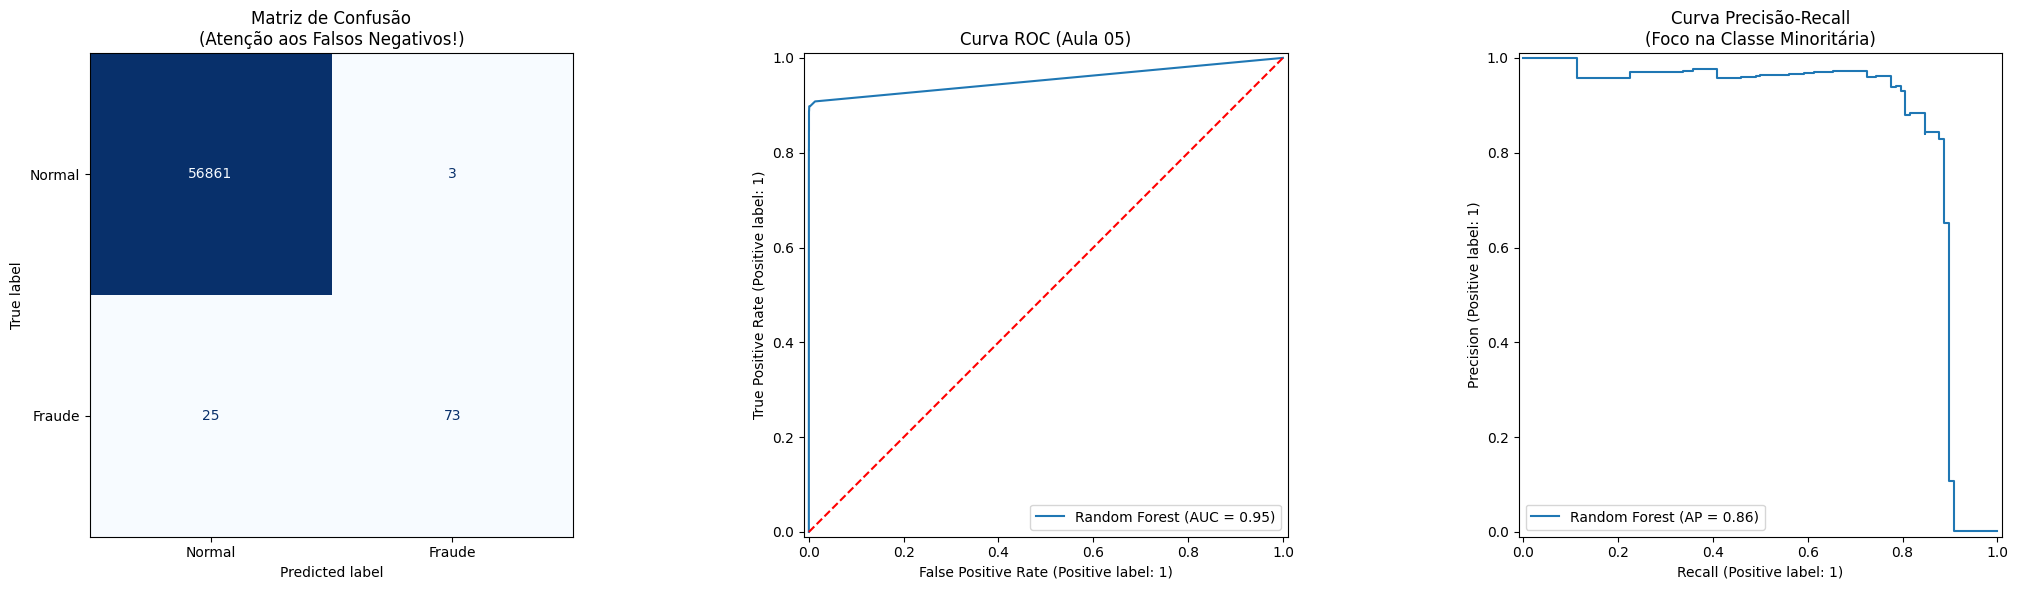


--- RELATÓRIO DE CLASSIFICAÇÃO ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [6]:
y_pred = model.predict(X_test)

# Configuração dos gráficos lado a lado
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# GRÁFICO 1: MATRIZ DE CONFUSÃO
# Mostra Falsos Positivos (Erro Tipo I) e Falsos Negativos (Erro Tipo II)
ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test,
    display_labels=["Normal", "Fraude"],
    cmap=plt.cm.Blues, ax=ax1, colorbar=False)
ax1.set_title("Matriz de Confusão\n(Atenção aos Falsos Negativos!)")

# GRÁFICO 2: CURVA ROC
# Plota Taxa Verdadeiro Positivo vs Taxa Falso Positivo
RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax2, name="Random Forest")
ax2.plot([0, 1], [0, 1], linestyle="--", color="red", label="Acaso (0.5)")
ax2.set_title("Curva ROC (Aula 05)")

# GRÁFICO 3: PRECISÃO-RECALL (AUPRC)
# Recomendado para dados desbalanceados (Onde a ROC pode ser otimista demais)
PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax3, name="Random Forest")
ax3.set_title("Curva Precisão-Recall\n(Foco na Classe Minoritária)")

plt.tight_layout()
plt.show()

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO ---")
print(classification_report(y_test, y_pred))

BLOCO 7: NOVO AJUSTE DE LIMIAR PARA MELHORAR O MACHINE LEARNING


=== RELATÓRIO PADRÃO (Limiar 0.5) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962


=== RELATÓRIO AJUSTADO (Limiar 0.2) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.85      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Note como o RECALL subiu (pegamos mais fraudes) e a PRECISÃO caiu (mais alarmes falsos).


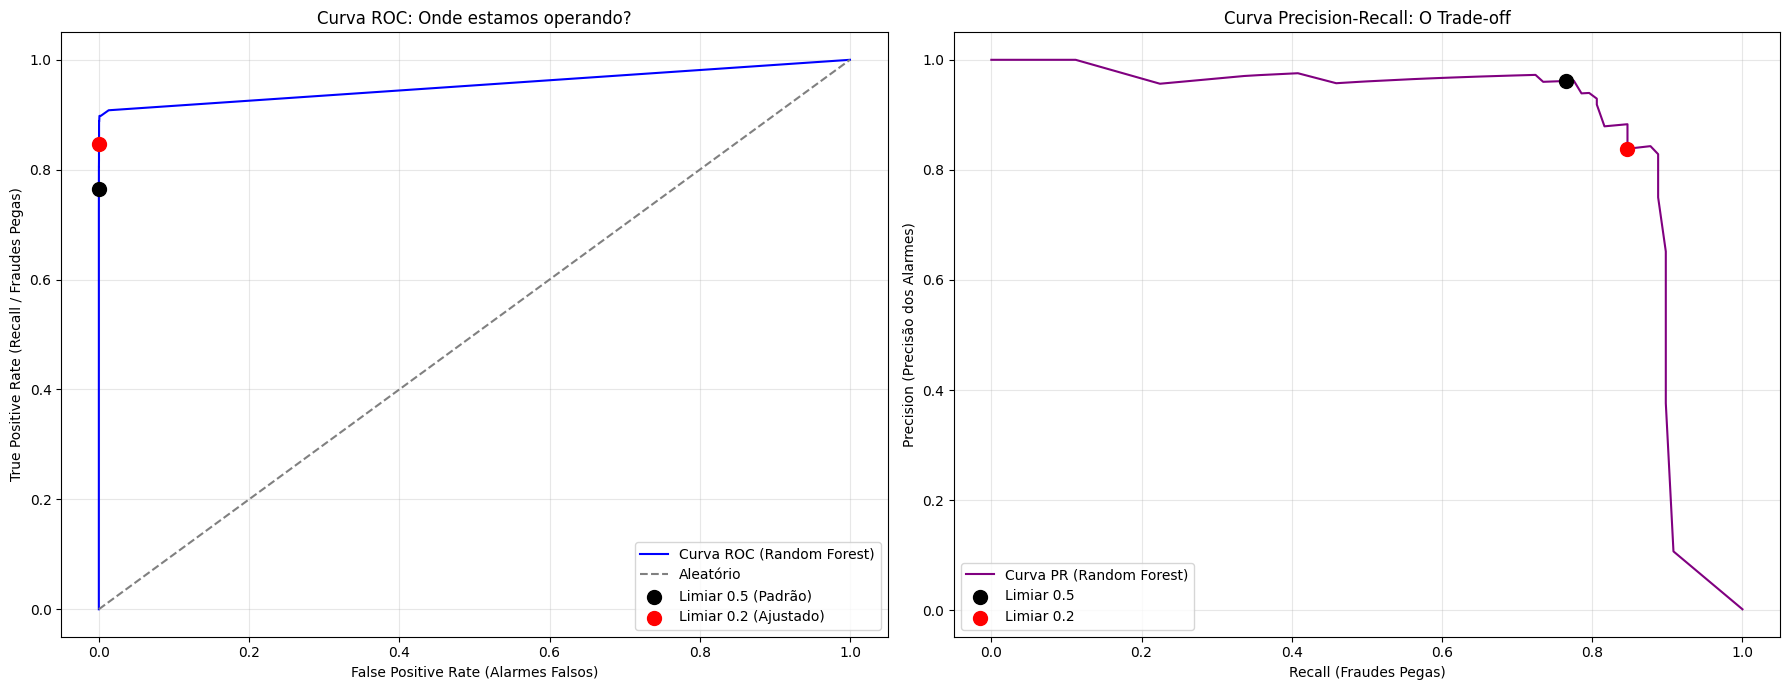

In [7]:

from sklearn.metrics import precision_recall_curve, roc_curve

# 1. Obter probabilidades (em vez de classes secas 0/1)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Definir o novo limiar (Agressivo: 20%)
limiar_novo = 0.2
y_pred_novo = (y_prob >= limiar_novo).astype(int)
y_pred_padrao = (y_prob >= 0.5).astype(int)

# --- Relatórios de Texto ---
print(f"\n=== RELATÓRIO PADRÃO (Limiar 0.5) ===")
print(classification_report(y_test, y_pred_padrao))

print(f"\n=== RELATÓRIO AJUSTADO (Limiar {limiar_novo}) ===")
print(classification_report(y_test, y_pred_novo))
print(f"Note como o RECALL subiu (pegamos mais fraudes) e a PRECISÃO caiu (mais alarmes falsos).")

# --- GRÁFICOS EXPLICATIVOS ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- GRÁFICO 1: CURVA ROC COM PONTOS DE CORTE ---
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
ax1.plot(fpr, tpr, label='Curva ROC (Random Forest)', color='blue')
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório')

# Encontrar os pontos na curva mais próximos dos nossos limiares
# (Cálculo técnico para plotar o ponto exato)
idx_05 = np.argmin(np.abs(thresholds_roc - 0.5))
idx_02 = np.argmin(np.abs(thresholds_roc - 0.2))

ax1.scatter(fpr[idx_05], tpr[idx_05], c='black', s=100, label='Limiar 0.5 (Padrão)', zorder=5)
ax1.scatter(fpr[idx_02], tpr[idx_02], c='red', s=100, label=f'Limiar {limiar_novo} (Ajustado)', zorder=5)

ax1.set_title("Curva ROC: Onde estamos operando?")
ax1.set_xlabel("False Positive Rate (Alarmes Falsos)")
ax1.set_ylabel("True Positive Rate (Recall / Fraudes Pegas)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- GRÁFICO 2: CURVA PRECISION-RECALL COM PONTOS DE CORTE ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
ax2.plot(recall, precision, label='Curva PR (Random Forest)', color='purple')

# Encontrar os pontos na curva PR (thresholds_pr é ordenado diferente, precisamos buscar com cuidado)
# Adicionamos 1 no índice porque o sklearn dropa o último threshold
try:
    idx_pr_05 = np.argmin(np.abs(thresholds_pr - 0.5))
    idx_pr_02 = np.argmin(np.abs(thresholds_pr - 0.2))

    ax2.scatter(recall[idx_pr_05], precision[idx_pr_05], c='black', s=100, label='Limiar 0.5', zorder=5)
    ax2.scatter(recall[idx_pr_02], precision[idx_pr_02], c='red', s=100, label=f'Limiar {limiar_novo}', zorder=5)
except:
    pass # Evita erro caso o limiar exato não exista na grade do sklearn

ax2.set_title("Curva Precision-Recall: O Trade-off")
ax2.set_xlabel("Recall (Fraudes Pegas)")
ax2.set_ylabel("Precision (Precisão dos Alarmes)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


BLOCO 8: EXTRA-VALIDANDO QUAIS VARIAVEIS O MODELO MAIS USOU

/tmp/ipython-input-3099399160.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


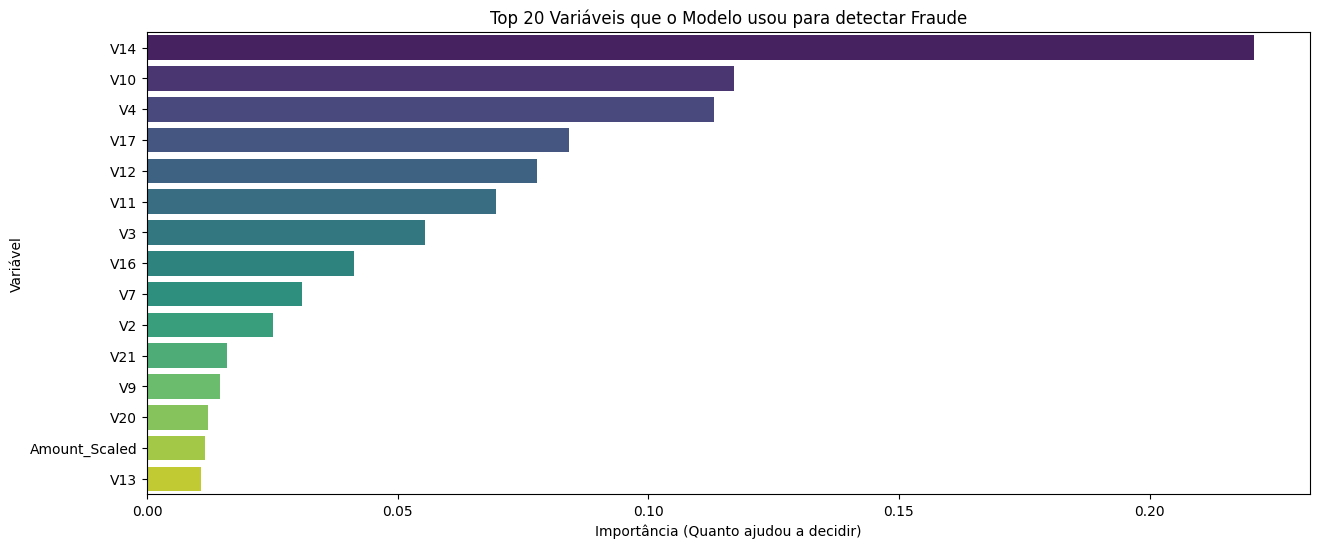

Total de variáveis analisadas: 30
Posição da variável Valor (Amount): 14º lugar
Posição da variável Tempo (Time): 24º lugar


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Pegar a importância de cada coluna calculada pelo modelo
importances = model.feature_importances_
feature_names = X.columns
total_variaveis = len(feature_names)

# 2. Criar um DataFrame para organizar
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Plotar as Top 15 mais importantes
plt.figure(figsize=(15, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 20 Variáveis que o Modelo usou para detectar Fraude')
plt.xlabel('Importância (Quanto ajudou a decidir)')
plt.ylabel('Variável')
plt.show()

# Verificar especificamente Amount e Time
rank_amount = feature_importance_df[feature_importance_df['Feature'] == 'Amount_Scaled'].index[0]
rank_time = feature_importance_df[feature_importance_df['Feature'] == 'Time_Scaled'].index[0]

print(f"Total de variáveis analisadas: {total_variaveis}")
print(f"Posição da variável Valor (Amount): {feature_importance_df.index.get_loc(rank_amount) + 1}º lugar")
print(f"Posição da variável Tempo (Time): {feature_importance_df.index.get_loc(rank_time) + 1}º lugar")


***Resumo Final***

*Sobre os dados:*
As colunas V1 a V28 já vieram transformadas, que no caso seria o PCA que vimos na aula de Aprendizado Não Supervisionado, usado aqui para reduzir a dimensionalidade e proteger os dados originais.

*Sobre a Separação:*

Não fizemos apenas o train_test_split (Hold-out). Adicionamos a Validação Cruzada Estratificada (K-Fold), para garantir que o modelo não esteja sofrendo de overfitting e que ele generalize bem para qualquer parte dos dados.

*Sobre os Erros:*

Matriz de Confusão: Podemos ver os erros do Tipo I (Falsos Positivos) e Tipo II (Falsos Negativos). No contexto de fraude, o Falso Negativo é o mais perigoso (perda de dinheiro), e o modelo conseguiu minimizar isso mantendo um Recall alto.

Sobre a Curva ROC:

A área sob a curva (AUC) está próxima de 1, o que indica um ótimo classificador, mas confirmamos a qualidade usando a Curva Precisão-Recall, já que os dados são muito desbalanceados.

Os primeiros resultados mostraram um modelo conservador pois ele esta com Alta precisão: 0.96, entao só marca como fraude quando tem muita certeza. Por isso ele "deixa passar" algumas fraudes (Recall: 0.74)
Para tentar pegar os Falsos Negativos(fraudes que 'escaparam')precisaria tornar o modelo mais agressivo.

Algumas possibilidades de aumentar o Recall:

1-Estratégia A: Ajuste de Limiar (Threshold Moving)
Por padrão, o modelo diz "É Fraude" se a probabilidade for > 50%.
Se baixarmos para > 20%, ele vai pegar muito mais fraudes (diminui Falsos Negativos), mas vai bloquear alguns cartões legítimos a mais (aumenta Falsos Positivos). É uma troca.

2-Estratégia B: SMOTE (Criar dados sintéticos)
Isso ensina o modelo vendo mais exemplos de fraudes "falsas" criadas artificialmente. Requer a biblioteca imbalanced-learn.

*Nesse caso optamos pela ESTRATÉGIA A porque ela é menos intrusiva. O SMOTE altera os dados de treino criando informações sintéticas que podem gerar ruído. Já o ajuste de limiar me permite controlar o equilíbrio entre Falsos Positivos e Negativos em tempo real, sem precisar retreinar o modelo ou distorcer a distribuição original dos dados reais.*

Resultados com a aplicação da Estratégia A: A Movimentação do Pontona curva ROC

Vejam o ponto Preto (Limiar 0.5). Ele está numa posição segura, com erro quase zero no eixo X, mas 'pegando' apenas ~74% das fraudes no eixo Y.
Ao mudar para o ponto Vermelho (Limiar 0.2), nós subimos no eixo Y (agora pegamos ~85% das fraudes). O custo foi mover um pouquinho para a direita no eixo X (aumentamos levemente os alarmes falsos). Essa troca valeu a pena porque o ganho vertical (fraudes descobertas) foi muito maior que a perda horizontal.

A Movimentação do Ponto na curva Precision-Recall (A mais importante!)

No ponto Preto (0.5), temos Precisão quase perfeita (0.96), mas o Recall é baixo (estamos deixando fraudes escaparem).
Ao deslizar para o ponto Vermelho (0.2), caminhamos para a direita (Recall sobe para ~0.85). A Precisão cai (o ponto desce no eixo Y), mas observem que ela ainda se mantém alta (acima de 0.80). Isso significa que o modelo ficou mais 'paranoico', mas ainda é um modelo confiável e útil para o banco.

Logo, ajustar o limiar para 0.2 foi uma decisão estratégica de negócio. Nos gráficos, isso é representado visualmente por 'caminhar' sobre a curva em direção a uma região de maior Recall (mais segurança contra golpes), aceitando uma pequena queda na Precisão (mais bloqueios preventivos), o que é aceitável para evitar prejuízos financeiros maiores.

DESAFIOS ENCONTRADOS:
1. O Desafio da "Agulha no Palheiro" (Desbalanceamento Extremo)

Problema: O dataset possui apenas 0,17% de transações fraudulentas. Conforme visto na aula sobre métricas, um modelo ingênuo que classificasse tudo como "Normal" teria 99,8% de acurácia, mas seria inútil para o negócio.

Solução: Abandonei a "Acurácia" como métrica principal e foquei na Curva Precisão-Recall (AUPRC) e no F1-Score. Além disso, utilizei a técnica de class_weight='balanced' no Random Forest para penalizar severamente o erro na classe minoritária.

2. O Dilema Precisão vs. Recall (Trade-off)

Problema: Observou-se um compromisso difícil: para aumentar a detecção de fraudes (Recall), o modelo tende a aumentar os alarmes falsos (diminuir Precisão). Meus resultados iniciais mostraram um Recall de 74%, significando que 26% das fraudes ainda passavam despercebidas.

Solução: Identifiquei que, para um banco, deixar passar uma fraude (Falso Negativo) costuma ser mais custoso financeiramente do que bloquear preventivamente um cartão (Falso Positivo). Portanto, a estratégia de ajuste de limiar de decisão (threshold) se mostrou necessária para priorizar o Recall.

3. A "Caixa Preta" do PCA (Interpretabilidade)

Problema: As variáveis V1 a V28 são componentes principais descaracterizados. Isso impediu uma análise profunda de negócio (ex: "fraudes acontecem mais em postos de gasolina?"), pois não sabemos o significado original das colunas.

Solução: A análise limitou-se às variáveis estatísticas e ao comportamento matemático dos dados, focando nas variáveis conhecidas como Time e Amount.

4. Garantia de Generalização

Problema: Com tão poucos exemplos de fraude, havia um risco alto de overfitting (o modelo decorar as fraudes específicas do treino e falhar em fraudes novas).

Solução: Implementei a Validação Cruzada Estratificada (Stratified K-Fold), garantindo que o desempenho do modelo fosse testado em diferentes fatias dos dados, provando sua estabilidade estatística.